In [1]:
%run my_functions.ipynb

In [2]:
from qiskit.circuit.library import QFT

In [3]:
def grover_operator(circuit,f_in,f_out,aux,aux1,aux2,n,sat_formula):
    circuit = hybrid_oracle(circuit,f_in,f_out,aux,aux1,n,sat_formula)
    circuit = diffusion_circ3(circuit,f_in,aux2)
    
    return circuit

def c_grover(sat_formula, power):
    
    n = max(max(sat_clause) for sat_clause in sat_formula)
    f_in = QuantumRegister(n)
    f_out = QuantumRegister(1)
    aux = QuantumRegister(len(sat_formula))
    aux1 = QuantumRegister(1)
    aux2 = QuantumRegister(2)

    qc = QuantumCircuit(f_in,f_out,aux,aux1,aux2)
    
    for i in range(2**power):
        qc = grover_operator(qc,f_in,f_out,aux,aux1,aux2,n,sat_formula)
    c_g = qc.to_gate().control()
    
    return c_g

In [4]:
def quantum_counting(sat_formula, m, e):   #m = requiered accuracy to determine M
                                           #e = required probability (1-e) to obtain M
    
    #Register 1
    reg1 = m + math.floor(math.log(2+0.5/e))
    t = QuantumRegister(reg1)
    
    #Register 2
    n = max(max(sat_clause) for sat_clause in sat_formula)
    f_in = QuantumRegister(n)
    f_out = QuantumRegister(1)
    aux = QuantumRegister(len(sat_formula))
    aux1 = QuantumRegister(1)
    aux2 = QuantumRegister(2)
    cr = ClassicalRegister(reg1)
    
    reg2 = n+1+len(sat_formula)+1+2
    
    circuit = QuantumCircuit(t,f_in,f_out,aux,aux1,aux2,cr)
    
    #Initial Superposition and set up
    circuit.h([t[i] for i in range(reg1)])
    circuit.h([f_in[i] for i in range(n)])
    circuit.x(f_out[0])
    circuit.barrier()
    
    #Adding control gates
    for i in range(reg1):
        index_list = [i]
        index_list += list(range(reg1,reg1+reg2))
        circuit.append(c_grover(sat_formula,i),index_list)
    circuit.barrier()
    
    #Inverse QFT
    circuit.append(QFT(reg1,inverse=False),list(range(0,reg1)))
    circuit.barrier()
    
    #Measurement
    circuit.measure(t[:],cr[:])
    
    return circuit
    

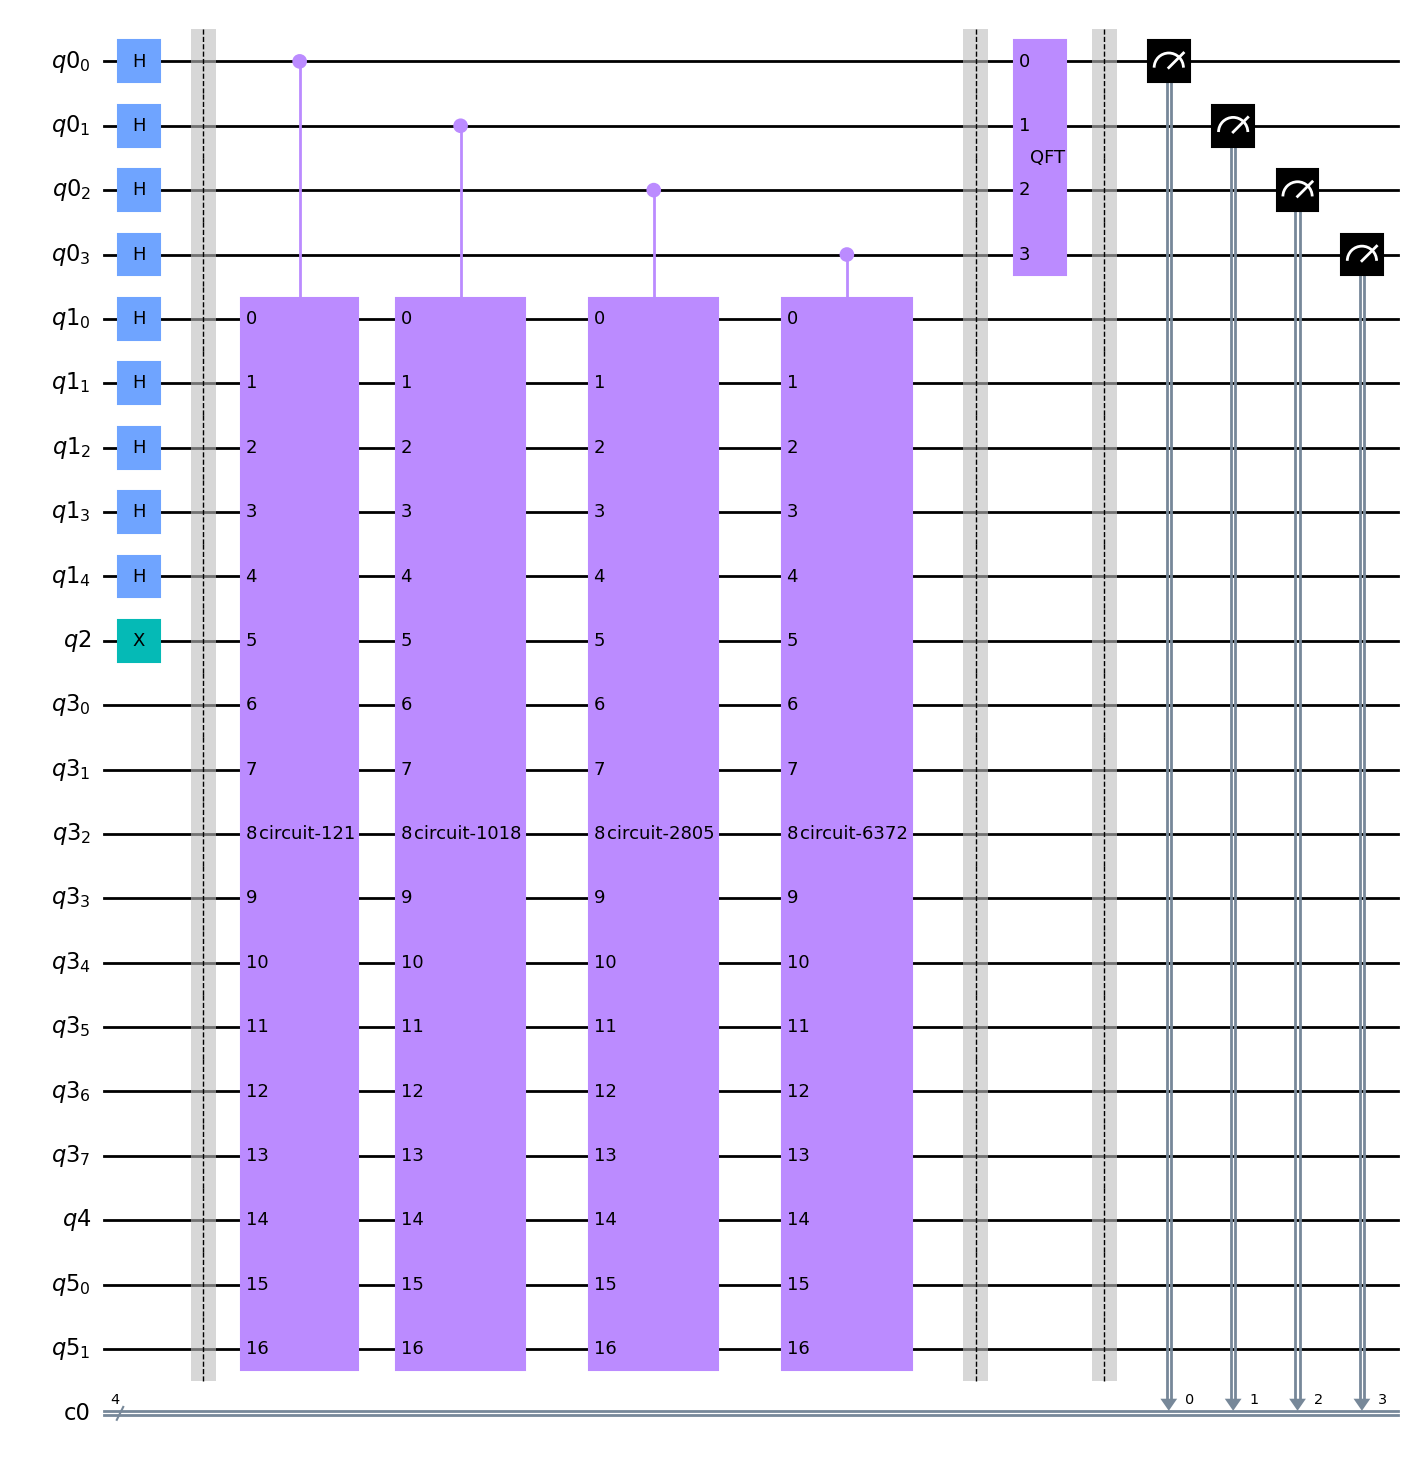

In [5]:
#Sat formula from hybrid problem 6
sat_formula = [[1,2,-3],[-1,-2,4],[2,-4,-5],[1,-3,5],[-1,3,-4],[3,4,-5],
               [2,3,-4],[-2,-3,5]]

#It has 11 solutions according to brute force method

m = 3
e = 1/10
circuit = quantum_counting(sat_formula,m,e)
circuit.draw('mpl')

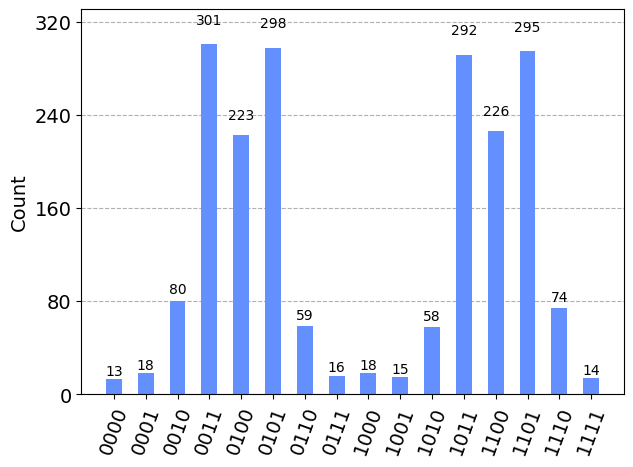

In [6]:
counts = execute(circuit,Aer.get_backend('qasm_simulator'),shots=2000).result().get_counts()
plot_histogram(counts)

In [7]:
measured_str = max(counts, key=counts.get)
measured_int = int(measured_str,2)
measured_int

3

In [8]:
#Number of marked elements
t = m + math.floor(math.log(2+0.5/e))
n = max(max(sat_clause) for sat_clause in sat_formula)
theta = (measured_int/(2**t))*math.pi*2 + math.pi
N = 2**n
M = N * (math.sin(theta/2)**2)
numsols = round(N-M)
numsols

10

In [9]:
round(M)

22

### Loop over m from 1 to n/2 or n and plot it. Try to make sense out of the plot

### Also, always add a qubit and increase the search space by 2 times. This provides an advantage when number of solution => N/2. Other cases, it might prove to get us a good approximated of num of solns in quantum counting algorithm

### Finding the behaviour of num of solutions as a function of m

In [10]:
n = max(max(sat_clause) for sat_clause in sat_formula)
N = 2**n
numsols = []
sols_rem = []
i = list(range(1,n+1))
for m in i:
    e = 1/10
    circuit = quantum_counting(sat_formula,m,e)
    counts = execute(circuit,Aer.get_backend('qasm_simulator'),shots=2000).result().get_counts()
    measured_str = max(counts, key=counts.get)
    measured_int = int(measured_str,2)
    #Number of marked elements
    t = m + math.floor(math.log(2+0.5/e))
    theta = (measured_int/(2**t))*math.pi*2 + math.pi
    M = N * (math.sin(theta/2)**2)
    numsols.append(round(N-M))
    sols_rem.append(M)

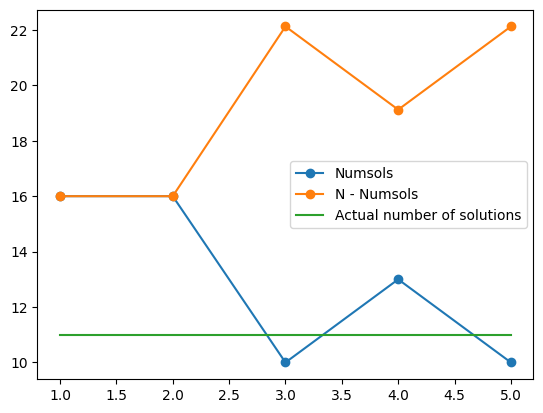

In [11]:
solution = [11]*len(i)
plt.plot(i,numsols, '-o', label='Numsols')
plt.plot(i,sols_rem,'-o', label='N - Numsols')
plt.plot(i,solution,label='Actual number of solutions')
plt.legend()

In [13]:
theta = []
num_iter = []
for i in range(len(numsols)):
    theta.append(math.sqrt(numsols[i]/N))
    num_iter.append(round(math.pi/(4*theta[i]) - 0.5))

In [14]:
theta

[0.7071067811865476,
 0.7071067811865476,
 0.5590169943749475,
 0.6373774391990981,
 0.5590169943749475]

In [15]:
num_iter

[1, 1, 1, 1, 1]